In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns  # Optional, for prettier confusion matrix plots

In [2]:
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
    images = batch[b'data']  # Image data (10,000 x 3072)
    labels = batch[b'labels']  # Corresponding labels
    return images, labels

def load_cifar10_dataset(root='C:/Users/ahosain/CIFAR10/cifar-10-batches-py'):
    train_images, train_labels = [], []

    # Load all training batches (data_batch_1 to data_batch_5)
    for i in range(1, 6):
        file_path = os.path.join(root, f"data_batch_{i}")
        images, labels = load_cifar10_batch(file_path)
        train_images.append(images)
        train_labels.extend(labels)

    # Load test batch (test_batch)
    test_images, test_labels = load_cifar10_batch(os.path.join(root, "test_batch"))

    # Convert to NumPy arrays and reshape to (N, 3, 32, 32)
    train_images = np.vstack(train_images).reshape(-1, 3, 32, 32).astype(np.float32)
    test_images = test_images.reshape(-1, 3, 32, 32).astype(np.float32)
    
    train_labels = np.array(train_labels, dtype=np.int64)
    test_labels = np.array(test_labels, dtype=np.int64)

    return train_images, train_labels, test_images, test_labels


In [3]:
train_images, train_labels, test_images, test_labels = load_cifar10_dataset()
print(f"Train images shape: {train_images.shape}")  # Expected: (50000, 3, 32, 32)
print(f"Test images shape: {test_images.shape}")      # Expected: (10000, 3, 32, 32)

# Normalize images to range [-1, 1]
train_images = train_images / 255.0 * 2 - 1
test_images = test_images / 255.0 * 2 - 1

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders for batch training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train images shape: (50000, 3, 32, 32)
Test images shape: (10000, 3, 32, 32)


In [4]:
class DeepMLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[1024, 512, 256, 128, 64], output_size=10):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
    
    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch 1/20: Train Loss: 1.9677, Val Loss: 1.7797, Train Acc: 26.92%, Val Acc: 36.78%
Epoch 2/20: Train Loss: 1.8213, Val Loss: 1.6969, Train Acc: 34.74%, Val Acc: 41.07%
Epoch 3/20: Train Loss: 1.7475, Val Loss: 1.6274, Train Acc: 37.92%, Val Acc: 43.95%
Epoch 4/20: Train Loss: 1.7112, Val Loss: 1.6491, Train Acc: 39.75%, Val Acc: 43.84%
Epoch 5/20: Train Loss: 1.6744, Val Loss: 1.6080, Train Acc: 41.23%, Val Acc: 44.15%
Epoch 6/20: Train Loss: 1.6508, Val Loss: 1.5725, Train Acc: 41.78%, Val Acc: 46.94%
Epoch 7/20: Train Loss: 1.6286, Val Loss: 1.5425, Train Acc: 43.02%, Val Acc: 46.50%
Epoch 8/20: Train Loss: 1.6057, Val Loss: 1.4982, Train Acc: 43.95%, Val Acc: 48.28%
Epoch 9/20: Train Loss: 1.5924, Val Loss: 1.5386, Train Acc: 44.42%, Val Acc: 46.54%
Epoch 10/20: Train Loss: 1.5804, Val Loss: 1.5249, Train Acc: 44.49%, Val Acc: 47.15%
Epoch 11/20: Train Loss: 1.5662, Val Loss: 1.4930, Train Acc: 45.33%, Val Acc: 48.58%
Epoch 12/20: Train Loss: 1.5550, Val Loss: 1.4929, Train Acc: 4

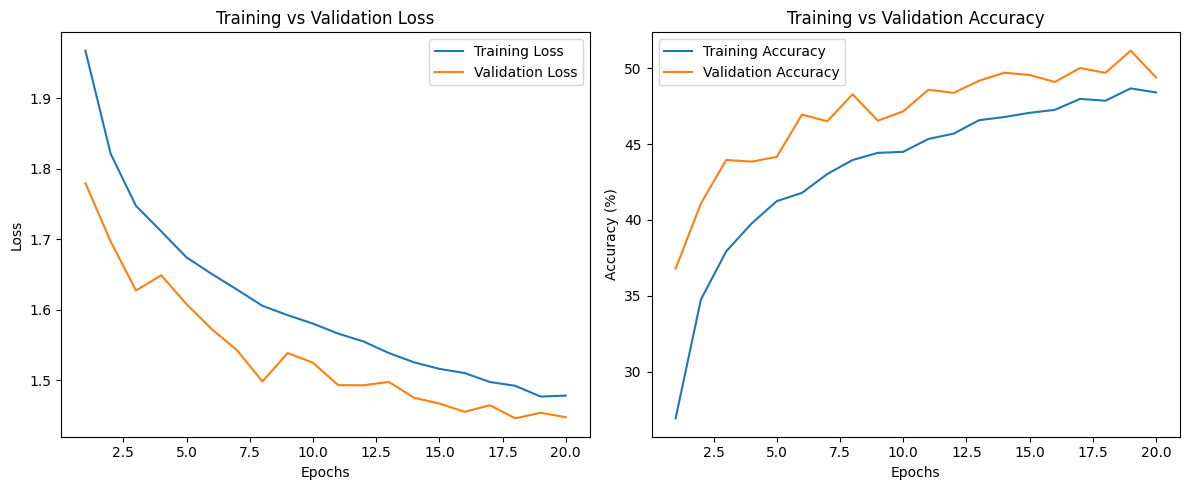

In [7]:
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [9]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.5514    0.5950    0.5724      1000
           1     0.6853    0.6010    0.6404      1000
           2     0.3847    0.2220    0.2815      1000
           3     0.2856    0.5170    0.3680      1000
           4     0.3574    0.5000    0.4168      1000
           5     0.6043    0.0840    0.1475      1000
           6     0.5519    0.6060    0.5777      1000
           7     0.7071    0.5070    0.5906      1000
           8     0.5829    0.7070    0.6390      1000
           9     0.5509    0.6010    0.5748      1000

    accuracy                         0.4940     10000
   macro avg     0.5262    0.4940    0.4809     10000
weighted avg     0.5262    0.4940    0.4809     10000



In [10]:
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Overall Precision (Macro Average): {precision:.4f}")
print(f"Overall Recall (Macro Average): {recall:.4f}")
print(f"Overall F1 Score (Macro Average): {f1:.4f}")


Overall Precision (Macro Average): 0.5262
Overall Recall (Macro Average): 0.4940
Overall F1 Score (Macro Average): 0.4809


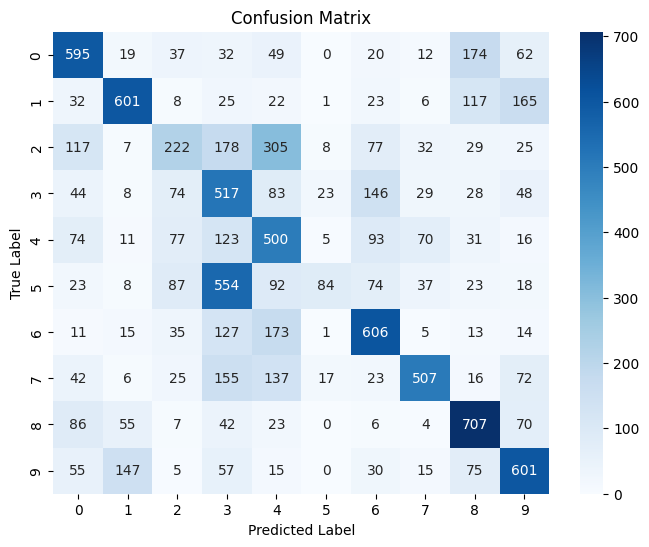

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()